# 🏠**Home Loan Approval Prediction**🏠

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [50]:
train = pd.read_csv('/content/loan_sanction_train.csv')
test = pd.read_csv('/content/loan_sanction_test.csv')

In [51]:
# summarize datafrane
def summarize_dataframe(df):
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']),
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']),
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])],
                     axis=1).set_index('Variable Name')
    return pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna("")


In [52]:
summarize_dataframe(train)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Loan_ID,object,0,614,614.0,614,LP001002,1,,,,,,,
Gender,object,13,2,601.0,2,Male,489,,,,,,,
Married,object,3,2,611.0,2,Yes,398,,,,,,,
Dependents,object,15,4,599.0,4,0,345,,,,,,,
Education,object,0,2,614.0,2,Graduate,480,,,,,,,
Self_Employed,object,32,2,582.0,2,No,500,,,,,,,
ApplicantIncome,int64,0,505,614.0,,,,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.0,81000.0
CoapplicantIncome,float64,0,287,614.0,,,,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,float64,22,203,592.0,,,,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0
Loan_Amount_Term,float64,14,10,600.0,,,,342.0,65.12041,12.0,360.0,360.0,360.0,480.0


In [53]:
summarize_dataframe(test)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Loan_ID,object,0,367,367.0,367,LP001015,1,,,,,,,
Gender,object,11,2,356.0,2,Male,286,,,,,,,
Married,object,0,2,367.0,2,Yes,233,,,,,,,
Dependents,object,10,4,357.0,4,0,200,,,,,,,
Education,object,0,2,367.0,2,Graduate,283,,,,,,,
Self_Employed,object,23,2,344.0,2,No,307,,,,,,,
ApplicantIncome,int64,0,314,367.0,,,,4805.599455,4910.685399,0.0,2864.0,3786.0,5060.0,72529.0
CoapplicantIncome,int64,0,194,367.0,,,,1569.577657,2334.232099,0.0,0.0,1025.0,2430.5,24000.0
LoanAmount,float64,5,144,362.0,,,,136.132597,61.366652,28.0,100.25,125.0,158.0,550.0
Loan_Amount_Term,float64,6,12,361.0,,,,342.537396,65.156643,6.0,360.0,360.0,360.0,480.0


## **Data Cleaning**

In [54]:
train.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


In [55]:
# drop Nas inboth test and train since they are not so many
train.dropna(inplace=True)
test.dropna(inplace=True)

In [56]:
# drop loan id
train = train.drop('Loan_ID', axis = 1)
test = test.drop('Loan_ID', axis = 1)

## **Exploratory Data Analysis**

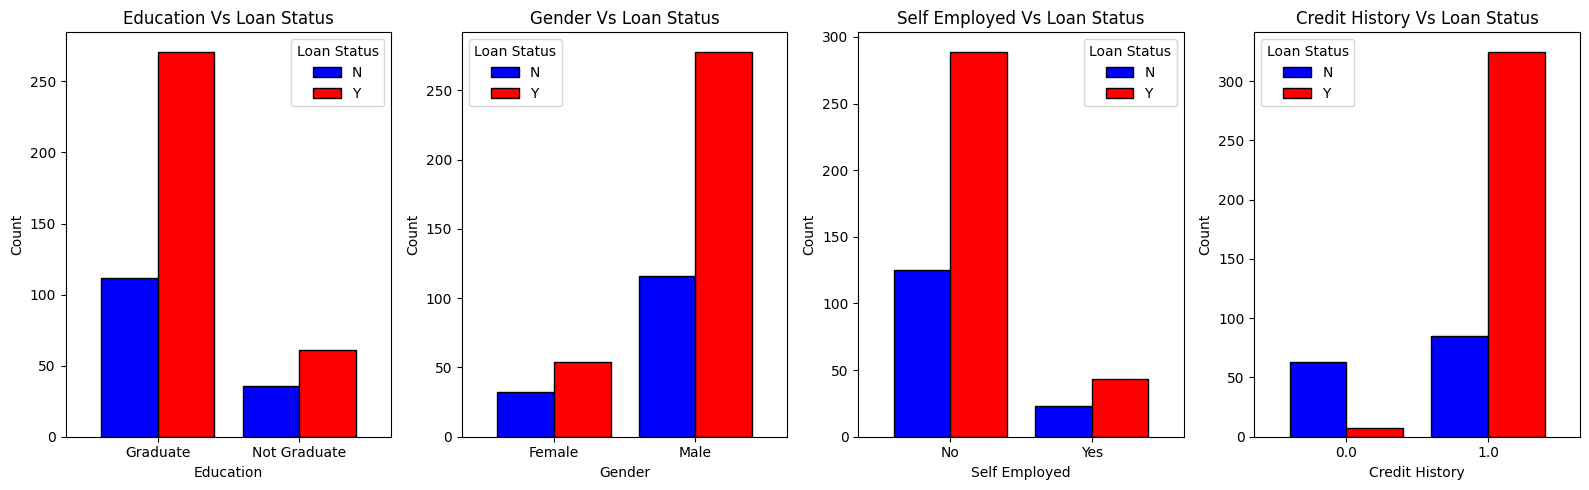

In [57]:
# Categorical columns for analysis
categories = ['Education', 'Gender', 'Self_Employed', 'Credit_History']

# Create subplots in a single row with multiple columns
fig, axes = plt.subplots(1, len(categories), figsize=(16, 5))

for col, ax in zip(categories, axes):
    col_label = col.replace("_", " ")

    # Group by the specified column and Loan_Status, then count occurrences
    df_grouped = train[[col, 'Loan_Status']].groupby([col, 'Loan_Status']).size().unstack().fillna(0)

    # Plot bar chart
    df_grouped.plot(kind='bar', ax=ax, color=['blue', 'red'], width=0.8, edgecolor='black')
    ax.set_title(f'{col_label} Vs Loan Status')
    ax.set_xlabel(col_label)
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title='Loan Status')

# Adjust layout
plt.tight_layout()
plt.show()



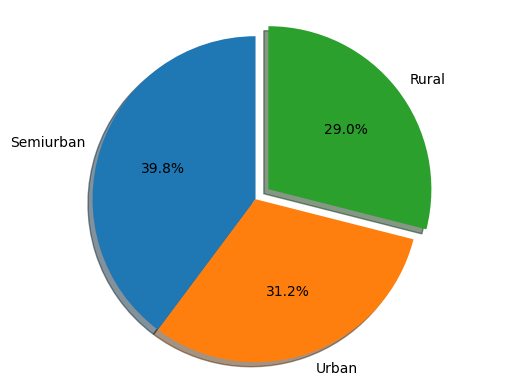

In [58]:
explode = (0, 0, 0.1)
labels = train.Property_Area.value_counts().index.tolist()  # Convert index to a list
sizes = train.Property_Area.value_counts().tolist()  # Get counts as a list

plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



## **Prep data for ML Modelling**

In [59]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = []

# Identify binary columns excluding 'Loan_Status'
for col in train.columns:
    if train[col].nunique() == 2 and train[col].dtype == 'object':
        categorical_columns.append(col)

# Apply label encoding to binary categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    train[col] = label_encoder.fit_transform(train[col])
    # Check if the column exists in the test set before applying the transformation
    if col in test.columns:
        test[col] = label_encoder.transform(test[col])


In [60]:
# One hot code Property Area
cols=['Dependents', 'Property_Area']
train = pd.get_dummies(data=train,
                     prefix=cols,
                     columns= cols)
test = pd.get_dummies(data=test,
                     prefix= cols,
                     columns= cols)


In [61]:
# slit in to traiing set into a subset of train  and validation set
X=train.drop('Loan_Status', axis=1)
y=train.Loan_Status

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=201)

In [62]:
# scale the data sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)


## Visualization

In [63]:
train.head(5)

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0,1,0,0,1,0,0
2,1,1,0,1,3000,0.0,66.0,360.0,1.0,1,1,0,0,0,0,0,1
3,1,1,1,0,2583,2358.0,120.0,360.0,1.0,1,1,0,0,0,0,0,1
4,1,0,0,0,6000,0.0,141.0,360.0,1.0,1,1,0,0,0,0,0,1
5,1,1,0,1,5417,4196.0,267.0,360.0,1.0,1,0,0,1,0,0,0,1


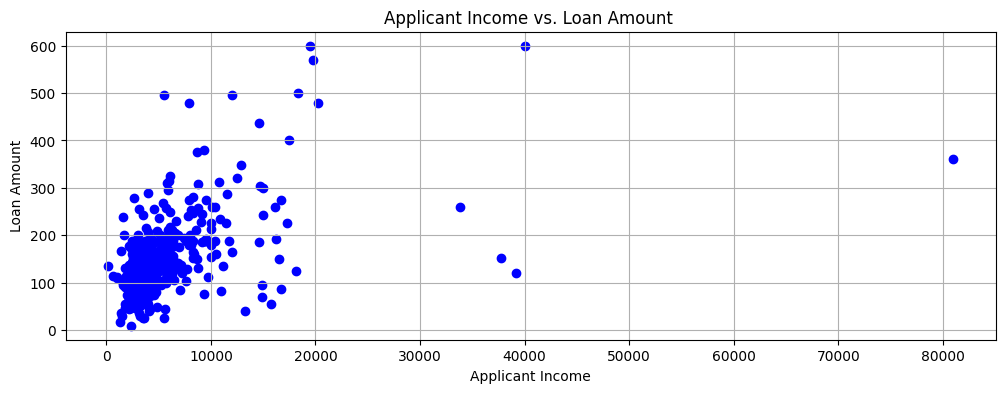

In [64]:
# Create the scatter plot
plt.figure(figsize = (12, 4))
plt.title("Applicant Income vs. Loan Amount ")

plt.grid()
plt.scatter(train["ApplicantIncome"], train["LoanAmount"], c = "b")
plt.xlabel("Applicant Income")
plt.ylabel("Loan Amount")

plt.show()

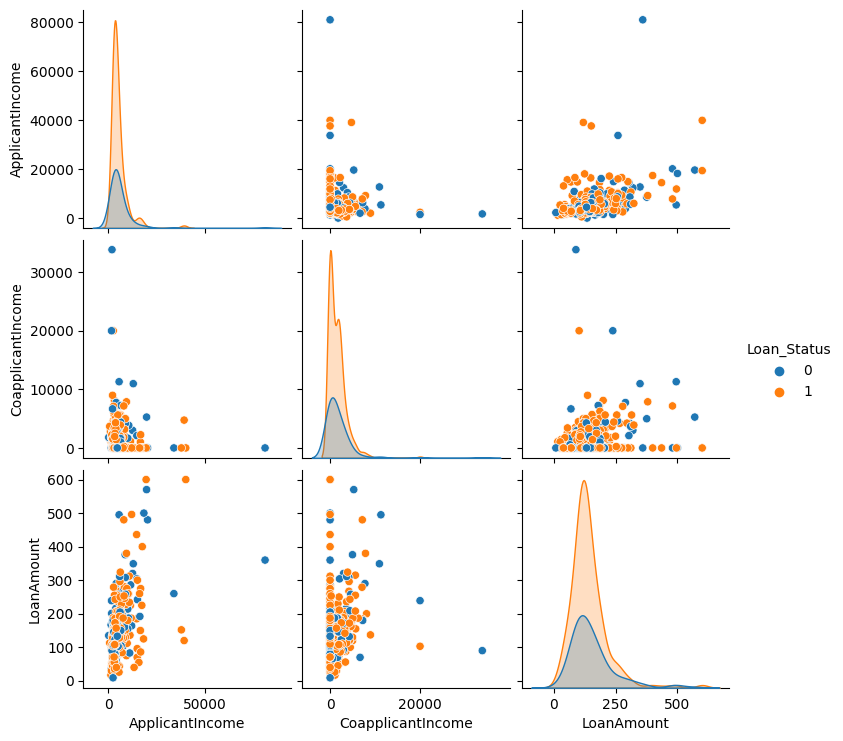

In [65]:
import seaborn as sns
numerical_features = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]

# Combine the target variable with the selected numerical features
data_to_plot = pd.concat([X[numerical_features], y], axis = 1)

# Create the pair plot
sns.pairplot(data_to_plot, hue = "Loan_Status", diag_kind = "kde")

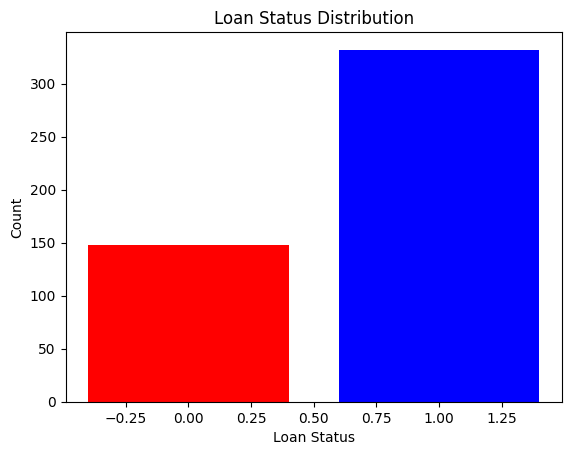

In [66]:

loan_status_counts = train['Loan_Status'].value_counts()
plt.bar(loan_status_counts.index, loan_status_counts, color=['blue', 'red'])

# Set title and labels
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')

# Show the plot
plt.show()


##**Model training**

In [67]:

# Define your classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Ridge Classifier': RidgeClassifier(),
    'XGBoost': XGBClassifier()
}

# Create an empty list to store DataFrames
dfs = []

for classifier_name, classifier in classifiers.items():
    # Create a pipeline with the classifier
    model = Pipeline(steps=[('classifier', classifier)])

    # Fit the classifier on scaled training data
    model.fit(X_train_scaled, y_train)

    # Predict on training and validation data
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)

    # Calculate classification metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Create a DataFrame for the current classifier's results
    result_df = pd.DataFrame({
        'Classifier': [classifier_name],
        'Train Accuracy': [train_accuracy],
        'Validation Accuracy': [val_accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })

    # Append the DataFrame to the list
    dfs.append(result_df)

# Concatenate all DataFrames in the list
results_df = pd.concat(dfs, ignore_index=True)

# Display the results
results_df


,Classifier,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score
0,Random Forest,1.000000,0.822917,0.820513,0.955224,0.882759
1,SVM,0.825521,0.822917,0.812500,0.970149,0.884354
2,Logistic Regression,0.815104,0.802083,0.800000,0.955224,0.870748
3,Ridge Classifier,0.809896,0.802083,0.800000,0.955224,0.870748
4,XGBoost,1.000000,0.760417,0.805556,0.865672,0.834532


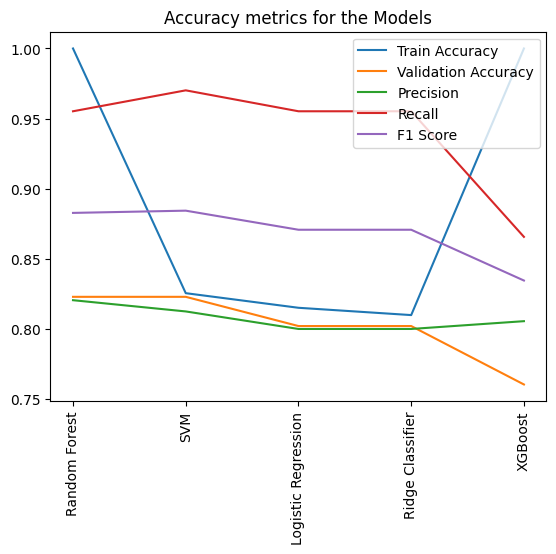

In [79]:
labels = ['Train Accuracy', 'Validation Accuracy', 'Precision', 'Recall', 'F1 Score']
model = results_df.Classifier
plt.plot(model, results_df['Train Accuracy'], model, results_df['Validation Accuracy'], model, results_df.Precision, model, results_df.Recall, model, results_df['F1 Score'])
plt.legend(labels, loc='upper right')
plt.xticks(rotation=90)
plt.title('Accuracy metrics for the Models')
plt.show()